# Implementation MFCC on Jupyter Notebook
#### Created by : M. Rizqi Subeno
- this notebook can check on : https://github.com/rizqisubeno/Tugas
- Refence the code : https://github.com/jameslyons/python_speech_features

In [32]:
import sys
import numpy as np

import matplotlib.pyplot as plt
import wave
import seaborn as sns

import IPython.display as ipd
from scipy.signal import lfilter
from scipy.io import wavfile
from scipy.fft import dct

%matplotlib inline
TRAIN_PATH = './'
name_file = "aldi.wav.coharos.wav"

In [33]:
raw = wave.open(TRAIN_PATH+name_file, mode='r')
n_channel = raw.getnchannels()
sample_rate = raw.getframerate()
n_frame = raw.getnframes()
duration = n_frame/raw.getframerate()
print("audio n-channel: {}".format(n_channel))
print("audio sample rate : {} Hz".format(sample_rate))
print("audio number frame : {}".format(n_frame))
print("audio duration : {:.3f} sec".format(duration))

#read all frame and visualize on matplotlib via np
audio_signal = raw.readframes(-1) # -1 indicates that read all frame
np_audio = np.frombuffer(buffer=audio_signal, dtype=np.int16)
# np_audio = np.array(signal_audio, dtype=np.int16)

audio n-channel: 1
audio sample rate : 44100 Hz
audio number frame : 53414
audio duration : 1.211 sec


# Preemphasis
The first step is to apply a pre-emphasis filter on the signal to amplify the high frequencies. A pre-emphasis filter is useful in several ways: 
1. balance the frequency spectrum since high frequencies usually have smaller magnitudes compared to lower frequencies
2. avoid numerical problems during the Fourier transform operation 
3. may also improve the Signal-to-Noise Ratio (SNR).

The pre-emphasis filter can be applied to a signal $x$ using the first order filter in the following equation:

$$y(t)=x(t)−αx(t−1)$$

which can be easily implemented using the following line, where typical values for the filter coefficient (α) are 0.95 or 0.97, (pre_emphasis = 0.97):

In [34]:
def preemphasis(signal, alpha=0.97):
    """
    Apply pre-emphasis filter on the input signal.
    
    Parameters:
    signal : array_like
        The input signal.
    alpha : float, optional
        The pre-emphasis coefficient. Default is 0.97.
        
    Returns:
    array_like
        The pre-emphasized signal.
    """
    # Apply pre-emphasis filter
    emphasized_signal = np.append(signal[0], signal[1:] - alpha * signal[:-1])
    
    return emphasized_signal

# Framing

After pre-emphasis, we need to split the signal into short-time frames. The rationale behind this step is that frequencies in a signal change over time, so in most cases it doesn’t make sense to do the Fourier transform across the entire signal in that we would lose the frequency contours of the signal over time. To avoid that, we can safely assume that frequencies in a signal are stationary over a very short period of time. Therefore, by doing a Fourier transform over this short-time frame, we can obtain a good approximation of the frequency contours of the signal by concatenating adjacent frames.

Typical frame sizes in speech processing range from 20 ms to 40 ms with 50% (+/-10%) overlap between consecutive frames. Popular settings are 25 ms for the frame size, frame_size = 0.025 and a 10 ms stride (15 ms overlap), frame_stride = 0.01

In [35]:
def framing(signal, frame_size, frame_stride, sample_rate=44100):
    """
    Frame the input signal into overlapping frames.
    
    Parameters:
    signal : array_like
        The input signal.
    frame_size : int
        The length of each frame (in samples).
    frame_stride : int
        The stride between consecutive frames (in samples).
    sample_rate : int
        sample rate signal usually : 44100
        
    Returns:
    array_like
        A 2D array where each row contains a frame of the input signal.
    """
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame
    #print("num frames : {}".format(num_frames))

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    return frames, frame_length

# Window
After slicing the signal into frames, we apply a window function such as the Hamming window to each frame. A Hamming window has the following form:
$$w[n]=0.54−0.46cos(\frac{2\pi n}{M−1})$$

or hanning window with following form :
$$w[n]=0.5−0.5cos(\frac{2\pi n}{M−1})$$

where, $0≤n≤M−1$, $M$ is the window length

In [36]:
def hamming(M):
    if M < 1:
        return np.array([], dtype=np.result_type(M, 0.0))
    if M == 1:
        return np.ones(1, dtype=np.result_type(M, 0.0))
    n = np.arange(1-M, M, 2)
    return 0.54 + 0.46*np.cos(np.pi*n/(M-1))

def hanning(M):
    if M < 1:
        return np.array([], dtype=np.result_type(M, 0.0))
    if M == 1:
        return np.ones(1, dtype=np.result_type(M, 0.0))
    n = np.arange(1-M, M, 2)
    return 0.5 + 0.5*np.cos(np.pi*n/(M-1))

def window(frame_length, window_func="hamming"):
    func = globals()[window_func]
    return func(frame_length)


# Fast Fourier Transform & Power Spectrum

We can now do an $N$-point FFT on each frame to calculate the frequency spectrum, which is also called Short-Time Fourier-Transform (STFT), where $N$ is typically 256 or 512, $NFFT = 256$; and then compute the power spectrum (periodogram) using the following equation :
$$P=\frac{|FFT(x_i)|^2}{N}$$

In [37]:
# under process do not use this function
def fft(x, fft_size):
    """
    Compute the fast Fourier transform (FFT) of a signal.

    Parameters:
    x (ndarray): The input signal.
    fft_size (int): The length of the FFT.

    Returns:
    ndarray: The FFT of the input signal.
    """
    # Ensure that the input signal is a np array
    x = np.asarray(x)

    # Check that the length of the input signal matches the FFT size
    if len(x) != fft_size:
        raise ValueError("Length of input signal does not match FFT size")

    # Compute the FFT recursively using the Cooley-Tukey algorithm
    if fft_size == 1:
        return x
    else:
        x_even = fft(x[::2], fft_size // 2)
        x_odd = fft(x[1::2], fft_size // 2)
        factor = np.exp(-2j * np.pi * np.arange(fft_size) / fft_size)
        return np.concatenate([x_even + factor[:fft_size // 2] * x_odd,
                               x_even + factor[fft_size // 2:] * x_odd])
    
def stft(x, window_size, hop_size, fft_size):
    """
    Compute the short-time Fourier transform (STFT) of a signal.

    Parameters:
    x (ndarray): The input signal.
    window_size (int): The length of the window function.
    hop_size (int): The number of samples to advance between each window.
    fft_size (int): The length of the FFT used in the STFT.

    Returns:
    ndarray: The STFT of the input signal.
    """
    # Calculate the number of frames
    n_frames = int(np.ceil((len(x) - window_size) / hop_size)) + 1

    # Zero-pad the signal to ensure all frames have the same length
    pad_size = ((n_frames - 1) * hop_size + window_size) - len(x)
    x = np.pad(x, (0, pad_size), 'constant')

    # Create the window function
    window = window(window_size, window_func="hamming")

    # Initialize the STFT matrix
    stft_matrix = np.zeros((n_frames, fft_size // 2 + 1), dtype=np.complex128)

    # Compute the STFT for each frame
    for i in range(n_frames):
        # Get the start and end indices for the current frame
        start = i * hop_size
        end = start + window_size

        # Apply the window to the current frame
        x_windowed = x[start:end] * window

        # Compute the FFT for the current frame
        x_fft = fft(x_windowed, fft_size)

        # Add the FFT to the STFT matrix
        stft_matrix[i, :] = x_fft[:fft_size // 2 + 1]

    return stft_matrix

In [38]:
def magspec(frames, NFFT):
    """Compute the magnitude spectrum of each frame in frames. If frames is an NxD matrix, output will be Nx(NFFT/2+1).

    :param frames: the array of frames. Each row is a frame.
    :param NFFT: the FFT length to use. If NFFT > frame_len, the frames are zero-padded.
    :returns: If frames is an NxD matrix, output will be Nx(NFFT/2+1). Each row will be the magnitude spectrum of the corresponding frame.
    """
    if np.shape(frames)[1] > NFFT:
        print("frame length {} is greater than FFT size {}, frame will be truncated. Increase NFFT to avoid."
              .format(np.shape(frames)[1], NFFT))
    complex_spec = np.fft.rfft(frames, NFFT)
    return np.absolute(complex_spec)

def powspec(frames, NFFT=512):
    """Compute the power spectrum of each frame in frames. If frames is an NxD matrix, output will be Nx(NFFT/2+1).

    :param frames: the array of frames. Each row is a frame.
    :param NFFT: the FFT length to use. If NFFT > frame_len, the frames are zero-padded.
    :returns: If frames is an NxD matrix, output will be Nx(NFFT/2+1). Each row will be the power spectrum of the corresponding frame.
    """
    return ((1.0 / NFFT) * np.square(magspec(frames, NFFT)))

# Filter Banks
The final step to computing filter banks is applying triangular filters, typically 40 filters, $nfilt = 40$ on a Mel-scale to the power spectrum to extract frequency bands. The Mel-scale aims to mimic the non-linear human ear perception of sound, by being more discriminative at lower frequencies and less discriminative at higher frequencies. We can convert between Hertz ($f$) and Mel ($m$) using the following equations:
$$f_{mel} = 2595*log_{10}(1+\frac{1}{700})$$
$$f_{Hz} = 700(10^{f_{mel}/2595}-1)$$

Each filter in the filter bank is triangular having a response of 1 at the center frequency and decrease linearly towards 0 till it reaches the center frequencies of the two adjacent filters where the response is 0, as shown in this figure:
![Mel_Filters](./mel_filters.jpg)
This can be modeled by the following equation :
$$H_m(k)=\begin{aligned}\begin{cases}
&0, &k<f(m-1)\\
&\frac{k-f(m-1)}{f(m)-f(m-1)}, &f(m-1)\leq k \leq f(m)\\
&\frac{f(m+1)-k}{f(m+1)-f(m)}, &f(m)\leq k \leq f(m+1)\\
&0, &k>f(m+1) \end{cases}\end{aligned}$$


In [39]:
def meltohz(mel):
    """Convert a value in Mels to Hertz

    :param mel: a value in Mels. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Hertz. If an array was passed in, an identical sized array is returned.
    """
    return 700*(10**(mel/2595.0)-1)

def hztomel(hz):
    """Convert a value in Hertz to Mels

    :param hz: a value in Hz. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Mels. If an array was passed in, an identical sized array is returned.
    """
    return 2595 * np.log10(1+hz/700.)

def get_fbank(power_frames, sample_rate, low_freq_hz=0, high_freq_hz=None, num_filter=40, NFFT=512): 
    high_freq_hz = high_freq_hz or sample_rate/2
    assert high_freq_hz <= sample_rate/2, "highfreq is greater than samplerate/2"

    low_freqmel = hztomel(low_freq_hz)
    high_freqmel = hztomel(high_freq_hz)
    mel_points = np.linspace(low_freqmel, high_freqmel, num_filter + 2)  # Equally spaced in Mel scale
    # our points are in Hz, but we use fft bins, so we have to convert
    #  from Hz to fft bin number
    bin = np.floor((NFFT + 1) * meltohz(mel_points) / sample_rate)

    fbank = np.zeros((num_filter, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, num_filter + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    feat = np.dot(power_frames, fbank.T)
    feat = np.where(feat == 0, np.finfo(float).eps, feat)  # Numerical Stability
    feat = 20 * np.log10(feat)  # dB
    #feat = np.log(feat)
    print("filter bank shape : {}".format(fbank.shape))
    return feat, fbank

# Mel-frequency Cepstral Coefficients (MFCCs)

It turns out that filter bank coefficients computed in the previous step are highly correlated because filter bank produce these coefficient are overlapping, which could be problematic in some machine learning algorithms. Therefore, we can apply Discrete Cosine Transform (DCT) to decorrelate the filter bank coefficients and yield a compressed representation of the filter banks. Typically, for Automatic Speech Recognition (ASR), the resulting cepstral coefficients 1-13 are retained and the rest are discarded; $num\_ceps = 13$. The reasons for discarding the other coefficients is that they represent fast changes in the filter bank coefficients and these fine details don’t contribute to Automatic Speech Recognition (ASR).

In [40]:

#One may apply sinusoidal liftering to the MFCCs to de-emphasize higher MFCCs 
#which has been claimed to improve speech recognition in noisy signals
def lifter(cepstra, L=22):
    """Apply a cepstral lifter the the matrix of cepstra. This has the effect of increasing the
    magnitude of the high frequency DCT coeffs.

    :param cepstra: the matrix of mel-cepstra, will be numframes * numcep in size.
    :param L: the liftering coefficient to use. Default is 22. L <= 0 disables lifter.
    """
    if L > 0:
        nframes,ncoeff = np.shape(cepstra)
        n = np.arange(ncoeff)
        lift = 1 + (L/2.)*np.sin(np.pi*n/L)
        return lift*cepstra
    else:
        # values of L <= 0, do nothing
        return cepstra
    
def get_cepstrumCoeff(feature, num_ceps=13, lifter_enable=True):
    ceps_coeff = dct(feature, type=2, axis=1, norm='ortho')[:,:num_ceps] # Keep 1-13
    if (lifter_enable):
        ceps_coeff = lifter(ceps_coeff, L=22)
    else:
        ceps_coeff = lifter(ceps_coeff, L=0)
    
    return ceps_coeff

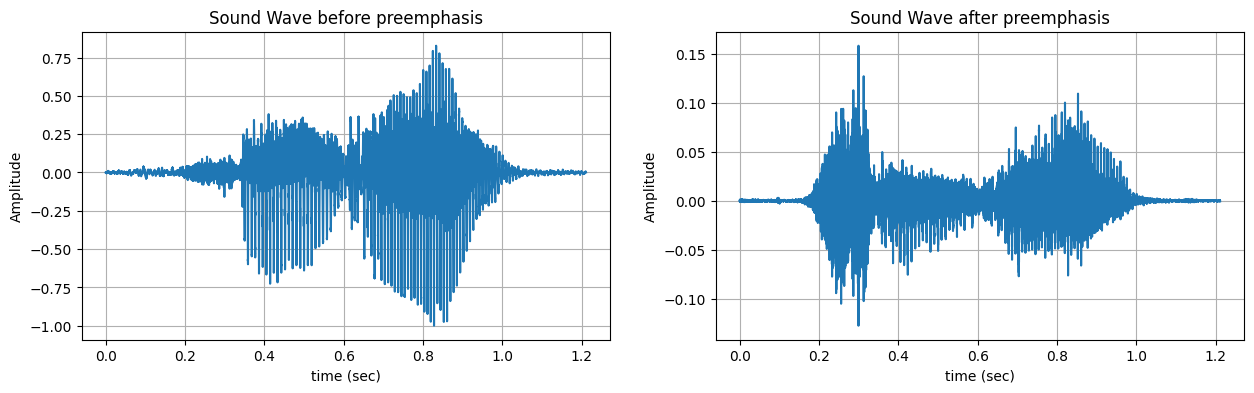

frame size : (119, 1102)


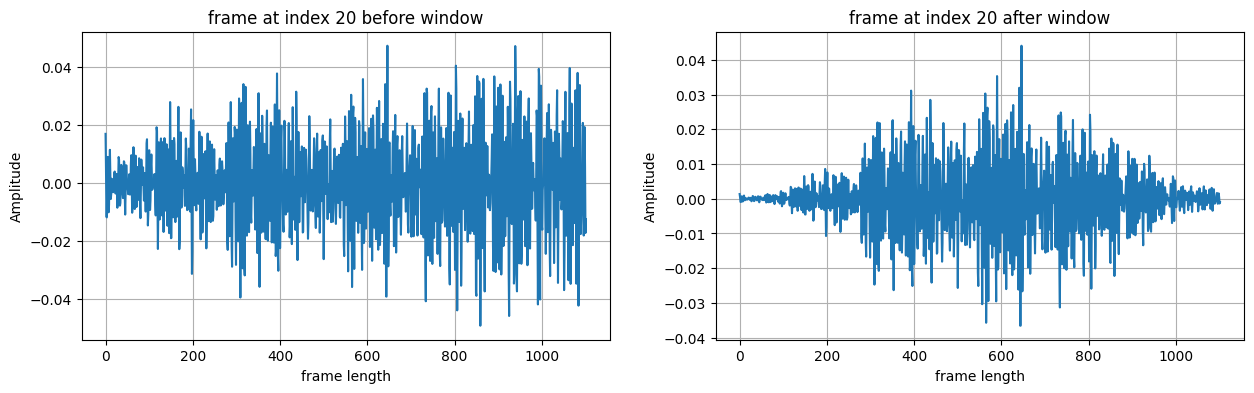

filter bank shape : (40, 1025)


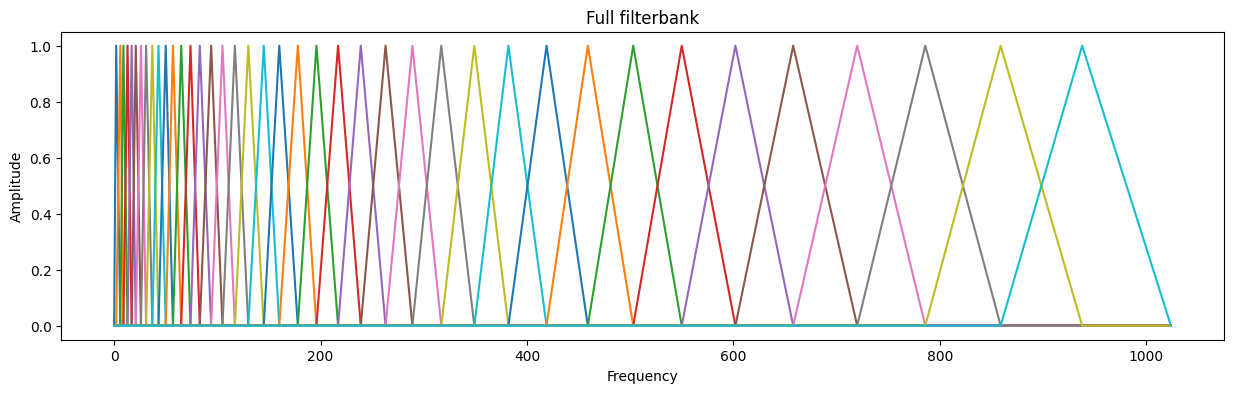

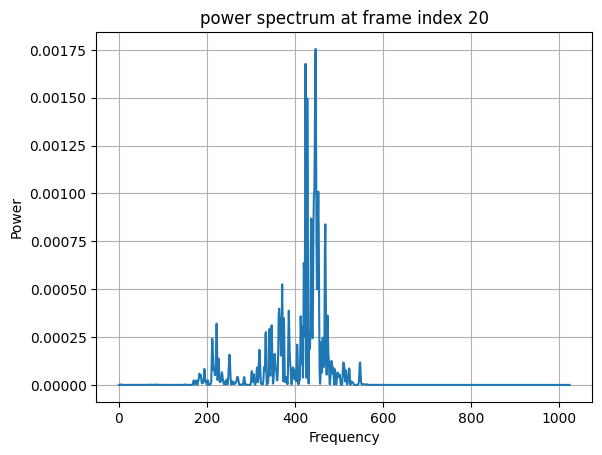

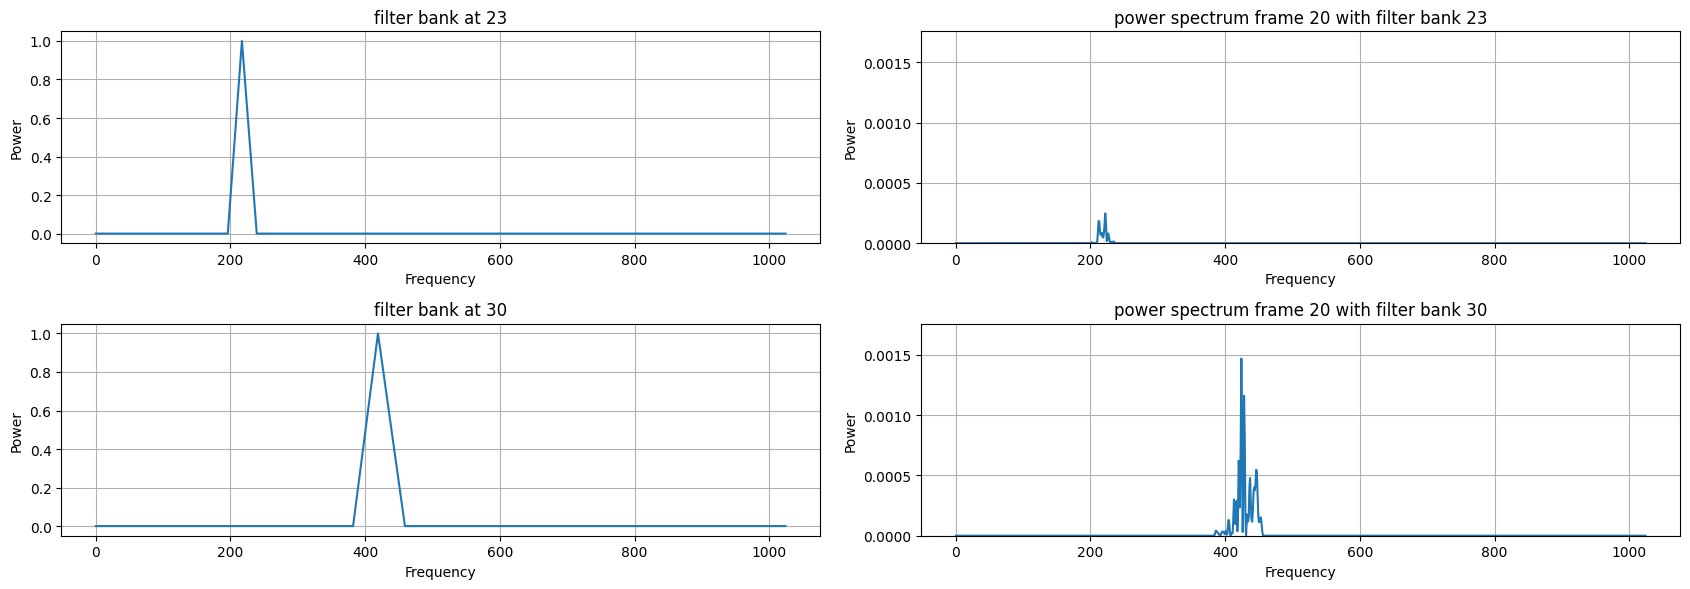

<Figure size 640x480 with 0 Axes>

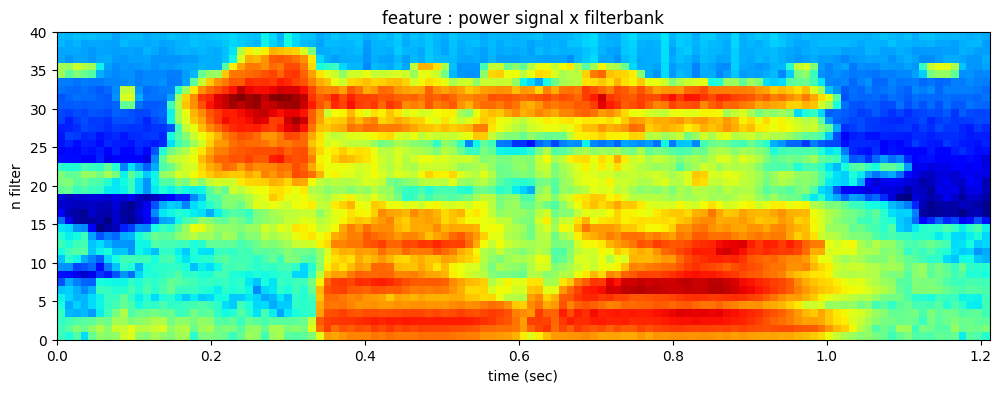

In [42]:
#pre-emphasis
np_audio = np_audio / np.max(np.abs(np_audio))
signal_preemphasis = preemphasis(np_audio, alpha=0.97)
# to Plot the x-axis in seconds you need get the frame rate
# and divide by size of your signal to create a Time Vector
# spaced linearly with the size of the audio file
x_axis = np.linspace(0,duration,num=len(signal_preemphasis))

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(x_axis,np_audio)
plt.xlabel("time (sec)")
plt.ylabel("Amplitude")
plt.title("Sound Wave before preemphasis")
plt.grid(True)
plt.subplot(122)
plt.plot(x_axis,signal_preemphasis)
plt.xlabel("time (sec)")
plt.ylabel("Amplitude")
plt.title("Sound Wave after preemphasis")
plt.grid(True)
plt.show()

#framing
frames, frame_len = framing(signal_preemphasis, frame_size=0.025, frame_stride=0.01, sample_rate=sample_rate)
print("frame size : {}".format(frames.shape))

#windowing
frames_window = frames * window(frame_len, window_func="hamming")

idx = 20
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(frames[idx])
plt.xlabel("frame length")
plt.ylabel("Amplitude")
plt.title("frame at index "+str(idx)+" before window")
plt.grid(True)
plt.subplot(122)
plt.plot(frames_window[idx])
plt.xlabel("frame length")
plt.ylabel("Amplitude")
plt.title("frame at index "+str(idx)+" after window")
plt.grid(True)
plt.show()

#power frame spectrum after calculated magnitude with FFT
power_frames = powspec(frames_window, NFFT=2048)

# get filter bank and calculation with power_frames to get feature
feature, fbank = get_fbank(power_frames, sample_rate=sample_rate, NFFT=2048)
plt.figure(figsize=(15,4))
for n in range(fbank.shape[0]):
    plt.plot(fbank[n])
plt.title("Full filterbank")
plt.ylabel("Amplitude")
plt.xlabel("Frequency")
plt.show()

plt.plot(power_frames[idx])
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("power spectrum at frame index "+str(idx))
plt.grid(True)
plt.show()
ylim = np.max(power_frames[idx])

plt.figure(figsize=(17,6))
plt.subplot(2,2,1)
idx1 = 23
plt.plot(fbank[idx1])
plt.ylabel("Power")
plt.xlabel("Frequency")
plt.title("filter bank at "+str(idx1))
plt.grid(True)
plt.tight_layout()

plt.subplot(2,2,2)
feat_idx1 = power_frames[idx]*fbank[idx1]
plt.plot(feat_idx1)
plt.ylabel("Power")
plt.xlabel("Frequency")
plt.title("power spectrum frame "+str(idx)+" with filter bank "+str(idx1))
plt.ylim(0,ylim)
plt.grid(True)
plt.tight_layout()

plt.subplot(2,2,3)
idx2 = 30
plt.plot(fbank[idx2])
plt.ylabel("Power")
plt.xlabel("Frequency")
plt.title("filter bank at "+str(idx2))
plt.grid(True)
plt.tight_layout()

plt.subplot(2,2,4)
feat_idx2 = power_frames[idx]*fbank[idx2]
plt.plot(feat_idx2)
plt.ylabel("Power")
plt.xlabel("Frequency")
plt.title("power spectrum frame "+str(idx)+" with filter bank "+str(idx2))
plt.ylim(0,ylim)
plt.grid(True)
plt.show()
plt.tight_layout()


plt.figure(figsize=(15,4))
plt.imshow(np.flipud(feature.T), cmap=plt.cm.jet, aspect=0.01, extent=[0,duration,0,40])
plt.xlabel("time (sec)")
plt.ylabel("n filter")
plt.title("feature : power signal x filterbank")
plt.show()

# get cepstrum coefficient and lifter the cepstrum
ceps_coefficient = get_cepstrumCoeff(feature, num_ceps=13, lifter_enable=True)

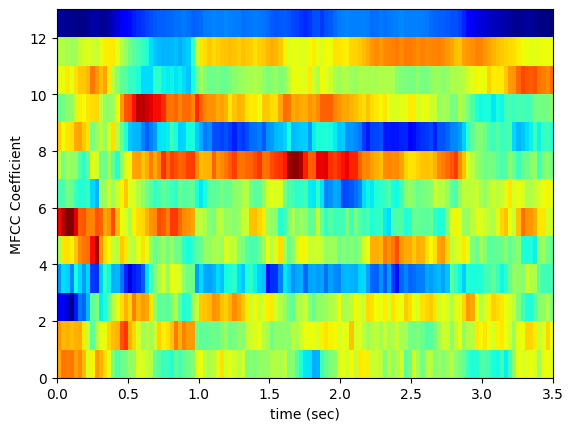

In [43]:
plt.imshow(ceps_coefficient.T, cmap=plt.cm.jet, aspect=0.2, extent=[0,3.5,0,13])
plt.xlabel("time (sec)")
plt.ylabel("MFCC Coefficient")
plt.show()
# sns.heatmap(ceps_coefficient.T)

In [44]:
# check result with library reference code to check if graph is same or not
from python_speech_features import mfcc

feature = mfcc(signal=np_audio, samplerate=sample_rate, winlen=0.025,winstep=0.01,numcep=13,
                 nfilt=40,nfft=2048,lowfreq=0,highfreq=None,preemph=0.97,
     ceplifter=22,appendEnergy=False)
print(feature.shape)

(120, 13)


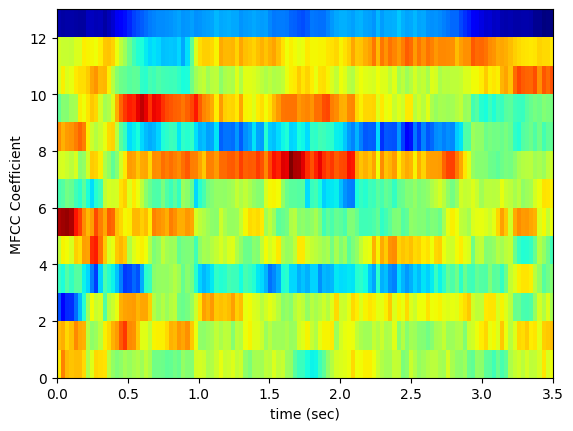

In [45]:
plt.imshow(feature.T, interpolation='nearest', cmap=plt.cm.jet, aspect=0.2, extent=[0,3.5,0,13])
plt.xlabel("time (sec)")
plt.ylabel("MFCC Coefficient")
plt.show()
# sns.heatmap(feature.T)